In [10]:
import numpy as np
import pandas as pd
from __future__ import annotations

from dataclasses import dataclass
from typing import Iterable, Tuple, Dict
import numpy as np
import pandas as pd


@dataclass
class _Accumulators:
    """Acumuladores para sumar contribuciones y contar apariciones por feature."""
    sum_signed: Dict[str, float]
    sum_abs: Dict[str, float]
    count: Dict[str, int]


def _resolve_feature_axis(expl) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Acepta ÚNICAMENTE Explanation con values de forma (n_samples, n_features, n_classes),
    donde len(feature_names) == n_features. Devuelve:
      - values_signed: (n_samples, n_classes, n_features)
      - values_abs   : (n_samples, n_classes, n_features)
      - feature_names: (n_features,)

    Si el objeto no cumple exactamente ese formato, lanza ValueError.
    """
    # 1) Nombres de features
    feature_names = getattr(expl, "feature_names", None) or getattr(expl, "data_feature_names", None)
    if feature_names is None:
        raise ValueError("No se encontraron nombres de features en la Explanation.")
    feature_names = np.asarray(feature_names)

    # 2) Valores SHAP
    values = np.asarray(expl.values)
    if values.ndim != 3:
        raise ValueError(
            f"Se esperaba values con 3 dimensiones (n_samples, n_features, n_classes); recibido {values.shape}."
        )

    n_samples, n_features, n_classes = values.shape
    if len(feature_names) != n_features:
        raise ValueError(
            f"Inconsistencia: len(feature_names)={len(feature_names)} != n_features={n_features}."
        )

    # (Opcional, estricto) validar base_values si existe
    base = getattr(expl, "base_values", None)
    if base is not None:
        base_arr = np.asarray(base)
        # Permitimos (n_samples, n_classes) o (n_classes,)
        if base_arr.ndim == 2:
            if base_arr.shape != (n_samples, n_classes):
                raise ValueError(
                    f"base_values debe tener forma (n_samples, n_classes)={ (n_samples, n_classes) }; "
                    f"recibido {base_arr.shape}."
                )
        elif base_arr.ndim == 1:
            if base_arr.shape[0] != n_classes:
                raise ValueError(
                    f"base_values debe tener longitud n_classes={n_classes}; recibido {base_arr.shape[0]}."
                )
        else:
            raise ValueError(
                f"base_values con dimensionalidad no soportada: {base_arr.shape}."
            )

    # 3) Reordenar a (n_samples, n_classes, n_features) para el pipeline aguas abajo
    values_signed = np.swapaxes(values, -1, -2)  # (n_samples, n_classes, n_features)
    values_abs = np.abs(values_signed)

    return values_signed, values_abs, feature_names

def _collapse_classes_to_sample_feature(
    signed_any: np.ndarray, abs_any: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Colapsa el eje de clases si existe:
      - Entrada 2D: (n_samples, n_features) -> se devuelve igual.
      - Entrada 3D: (n_samples, n_classes, n_features)
          * con signo: promedio por clase
          * en valor absoluto: promedio de absolutos por clase
      Devuelve dos arrays 2D: (n_samples, n_features).
    """
    if signed_any.ndim == 2:
        return signed_any, abs_any
    if signed_any.ndim == 3:
        signed_sf = signed_any.mean(axis=1)
        abs_sf = abs_any.mean(axis=1)
        return signed_sf, abs_sf
    raise ValueError("Formas SHAP inesperadas tras normalización/clase.")


def _validate_feature_alignment(n_features: int, feat_names: np.ndarray) -> None:
    """Valida que la cantidad de columnas coincida con la cantidad de nombres de features."""
    if len(feat_names) != n_features:
        raise ValueError(
            f"Longitud de feature_names ({len(feat_names)}) no coincide con n_features ({n_features}). "
            "Esto indica una incongruencia en el objeto SHAP o en el mapeo de nombres."
        )


def _accumulate_fold_contributions(
    acc: _Accumulators,
    feat_names: np.ndarray,
    shap_signed_sf: np.ndarray,
    shap_abs_sf: np.ndarray,
) -> None:
    """
    Agrega al acumulador:
      - sumas por feature (con signo y absoluto) sobre las muestras del fold
      - conteo de apariciones (n_samples por feature en este fold)
    """
    n_samples, n_features = shap_signed_sf.shape
    fold_sum_signed = shap_signed_sf.sum(axis=0)
    fold_sum_abs = shap_abs_sf.sum(axis=0)

    for j, feature_name in enumerate(feat_names):
        acc.sum_signed[feature_name] = acc.sum_signed.get(feature_name, 0.0) + float(fold_sum_signed[j])
        acc.sum_abs[feature_name] = acc.sum_abs.get(feature_name, 0.0) + float(fold_sum_abs[j])
        acc.count[feature_name] = acc.count.get(feature_name, 0) + n_samples


def _build_result_dataframe(acc: _Accumulators) -> pd.DataFrame:
    """Construye el DataFrame final (ordenado por mean_abs_shap desc)."""
    rows = []
    for feature_name, feature_count in acc.count.items():
        mean_signed = acc.sum_signed[feature_name] / feature_count if feature_count else np.nan
        mean_abs = acc.sum_abs[feature_name] / feature_count if feature_count else np.nan
        rows.append((feature_name, feature_count, mean_signed, mean_abs))

    df = pd.DataFrame(rows, columns=["feature", "count", "mean_shap", "mean_abs_shap"])
    df = df.sort_values("mean_abs_shap", ascending=False, kind="mergesort").reset_index(drop=True)
    return df


def aggregate_shap_explanations(explanations: Iterable) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Agrega una lista de shap.Explanation (una por fold) y devuelve:
      - df_agg: DataFrame con columnas ['feature', 'count', 'mean_shap', 'mean_abs_shap'],
                ordenado por 'mean_abs_shap' descendente.
      - top20 : DataFrame con las 20 features más importantes por 'mean_abs_shap'.

    Reglas:
      * Considera todas las muestras de test por fold.
      * Si hay eje de clases, colapsa promediando por clase tanto con signo como en valor absoluto.
      * 'count' = # apariciones (muestras × folds en los que la feature estuvo presente).
      * No imputa ceros para folds donde la feature no aparece.

    Parámetros
    ----------
    explanations : Iterable[shap.Explanation]
        Lista (o iterable) devuelta por shap_after_nested_cv(...), una Explanation por fold.

    Retorna
    -------
    df_agg : pd.DataFrame
    top20  : pd.DataFrame
    """
    explanations = list(explanations)
    if not explanations:
        raise ValueError("La lista de explanations está vacía.")

    acc = _Accumulators(sum_signed={}, sum_abs={}, count={})

    for expl in explanations:
        signed_any, abs_any, feat_names = _resolve_feature_axis(expl)
        shap_signed_sf, shap_abs_sf = _collapse_classes_to_sample_feature(signed_any, abs_any)
        _validate_feature_alignment(shap_signed_sf.shape[1], feat_names)
        _accumulate_fold_contributions(acc, feat_names, shap_signed_sf, shap_abs_sf)

    df_agg = _build_result_dataframe(acc)
    top20 = df_agg.head(20).copy()
    return df_agg, top20



In [2]:
from src.model.shap.run_shap import run_shap

explanations = run_shap(
        dataset_name="demographic+digital",
        target_col="group",
        task="classification",
        model_name_to_explain="SVC",
        timestamp="2025-09-12_1559"
    )


/home/gianluca/Research/tmt-analysis/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers.

In [3]:
explanations

[.values =
 array([[[ 0.02913744, -0.02913744],
         [-0.00266133,  0.00266133],
         [ 0.00828206, -0.00828206],
         [ 0.00520502, -0.00520502],
         [ 0.00826218, -0.00826218],
         [ 0.0102743 , -0.0102743 ],
         [-0.04829066,  0.04829066],
         [ 0.00189033, -0.00189033],
         [-0.02074239,  0.02074239],
         [ 0.00472806, -0.00472806],
         [-0.00337509,  0.00337509],
         [-0.05395541,  0.05395541],
         [ 0.00241199, -0.00241199],
         [ 0.00680559, -0.00680559],
         [ 0.00316137, -0.00316137],
         [-0.06731603,  0.06731603],
         [ 0.01466766, -0.01466766],
         [ 0.01108831, -0.01108831],
         [-0.02358996,  0.02358996],
         [-0.00507219,  0.00507219]]])
 
 .base_values =
 array([[0.48057801, 0.51942199]])
 
 .data =
 array([[ 1.22870466,  0.49057918, -0.83894   , -0.0395364 ,  0.14298255,
          0.62999382, -0.69400903,  0.62892401,  0.70820402,  0.0282486 ,
          0.50892069,  1.80972832, 

In [11]:
df_agg, top20  = aggregate_shap_explanations(explanations)

In [5]:
df_agg[df_agg["count"] >11]

,feature,count,mean_shap,mean_abs_shap
2,non_cut_correct_targets_touches_PART_B,74,-6.790915e-18,0.041838
3,is_valid_sum_B,74,-5.186589e-18,0.039199
5,non_cut_correct_targets_touches_B_A_ratio,74,-4.305308e-18,0.032475
10,non_cut_rt_PART_B,74,-2.036542e-18,0.019294
11,age,74,1.534366e-18,0.019258
12,max_duration_PART_B,71,-2.383718e-18,0.018140
13,state_transitions_B_A_ratio,74,-7.189433e-18,0.017645
15,non_cut_correct_targets_touches_PART_A,74,3.661380e-18,0.016594
16,average_duration_PART_B,73,-3.899415e-18,0.016189
17,travel_avg_speed_B_A_ratio,61,1.293933e-18,0.013433


In [6]:
import matplotlib.pyplot as plt

def plot_mean_abs_shap(df, top_n=20, figsize=(8, 6)):
    """
    Plotea las mean absolute SHAP values de las features más importantes.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de aggregate_shap_explanations con columnas:
        ['feature', 'count', 'mean_shap', 'mean_abs_shap']
    top_n : int
        Número de features a mostrar (default=20).
    figsize : tuple
        Tamaño de la figura (default=(8, 6)).

    Devuelve
    --------
    fig, ax : objetos de matplotlib
    """
    # Ordenar por importancia absoluta descendente y coger top_n
    df_plot = df.sort_values("mean_abs_shap", ascending=False).head(top_n)

    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(df_plot["feature"], df_plot["mean_abs_shap"], color="steelblue")
    ax.set_xlabel("Mean |SHAP value|")
    ax.set_ylabel("Feature")
    ax.set_title(f"Top {top_n} features by mean |SHAP|")
    ax.invert_yaxis()  # Para que la más importante quede arriba

    plt.tight_layout()
    return fig, ax


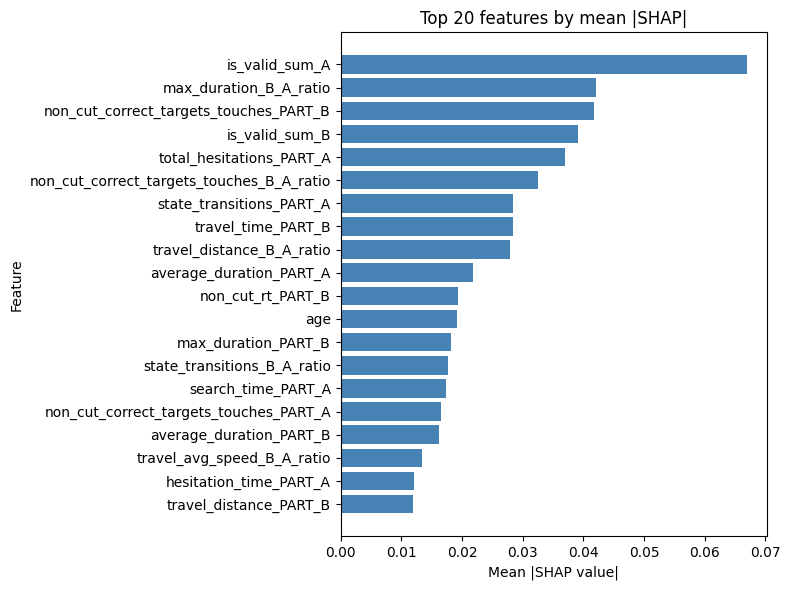

In [7]:
plot_mean_abs_shap(df_agg, top_n=20)
plt.show()